# Construção do léxico consolidado do VADER

In [11]:
import pandas as pd
import numpy as np
import re


## Carrega traducao do VADER mais casos manuais ###################
# le arquivo traduzido com anotacoes manuais
df = pd.read_csv('datasets/vader_lexicon_translated_mais_manual.txt', sep='\t', names=['sintagma', 'polaridade', 'ingles'])
# agrupa e faz media
dfDistinct = df.loc[:][ ['sintagma', 'polaridade']].groupby('sintagma').mean().reset_index(drop=False)


## Inclusao sinonimos do OpenThesaurus ###################
# verifica sinonimos
dfSinonimos = pd.read_csv('datasets/Thesaurus.txt', sep='\t', encoding = "ISO-8859-15", skiprows=11, names=['palavra'])
dfSinonimos = dfSinonimos.apply(lambda row : row.str.split(';'), axis=1).explode('palavra').reset_index(drop=False).rename(columns={'index': 'synset'})
dfSinonimos = dfSinonimos.merge(right = dfSinonimos, how='inner' , on='synset' )
dfSinonimos = dfSinonimos[dfSinonimos.palavra_x != dfSinonimos.palavra_y]
dfSinonimos = dfSinonimos.rename(columns={'palavra_x': 'sintagma', 'palavra_y': 'sinonimo'})
dfCruzado = pd.merge(left=dfDistinct, right=dfSinonimos, on='sintagma', how='inner')
dfCruzado = pd.merge(left=dfDistinct, right=dfCruzado, left_on='sintagma', right_on='sinonimo', how='right')
dfNovasPalavras = dfCruzado[dfCruzado.sintagma_x.isna()].loc[:, ['sinonimo', 'polaridade_y']]
dfNovasPalavras = dfNovasPalavras.groupby('sinonimo').mean().reset_index(drop=False).sort_values(by='sinonimo')
dfNovasPalavras = dfNovasPalavras.rename(columns={'sinonimo': 'sintagma', 'polaridade_y': 'polaridade'})
# remove falsas associações (verificação humana)
exclusoes = ['avaliação', 'grupo', 'base', 'atenção', 'valor', 'negocio', 'titulos', 'numeros']
for w in exclusoes:
    dfNovasPalavras = dfNovasPalavras [ dfNovasPalavras['sintagma'] != w ] 
# remove palavras curtas 
dfNovasPalavras = dfNovasPalavras [ dfNovasPalavras['sintagma'].str.len() > 3 ] 
# remove lista de exclusão
dfExclusao = pd.read_excel('datasets/palavras_excluir_thesaurus.xlsx')
dfNovasPalavras = pd.merge(left=dfNovasPalavras, right=dfExclusao, on=['sintagma'], how='inner')
dfNovasPalavras = dfNovasPalavras[dfNovasPalavras.excluir != 'S'].loc[:, ['sintagma', 'polaridade_x']].rename(columns={'polaridade_x' : 'polaridade'})
dfNovasPalavras['Fonte'] = 'OpenThesaurusPT'

## Faz a marcação dos termos manuais ou que vieram da tradução  ######

dfTraduzidoOriginal = pd.read_csv('datasets/vader_lexicon_translated_original.txt', sep='\t', names=['sintagma', 'polaridade', 'ingles'])
# agrupa e faz media
dfTraduzidoOriginal = dfTraduzidoOriginal.loc[:][ ['sintagma', 'polaridade']].groupby('sintagma').mean().reset_index(drop=False)
dfTraduzido = pd.merge(left=dfDistinct, right=dfTraduzidoOriginal, on=['sintagma'], how='left').rename(columns={'polaridade_x': 'polaridade'})
dfTraduzido['Fonte'] = dfTraduzido['polaridade_y'].apply(lambda x : 'Vader+Google Translator' if not pd.isnull(x) else 'Manual')
del dfTraduzido['polaridade_y']

## Consolidação ######################################################

# junta os dfs e salva
df = pd.concat([dfTraduzido, dfNovasPalavras]).sort_values(by='sintagma')
df.to_csv('datasets/vader_lexico_ptbr.txt', sep='\t', index=False, header=False)



In [12]:
## sentilex https://b2find.eudat.eu/dataset/b6bd16c2-a8ab-598f-be41-1e7aeecd60d3

# carrega expressoes
dfSentiLexExpressoes = pd.read_excel('datasets/expressoes_senti_lex_adicionar.xlsx')
df = pd.concat([dfTraduzido, dfNovasPalavras, dfSentiLexExpressoes]).sort_values(by='sintagma')
df.to_csv('datasets/vader_lexico_ptbr.txt', sep='\t', index=False, header=False)


# faz as flexoes

dfSentiLex = pd.read_csv('datasets/SentiLex-flex-PT02.txt', sep=';', names=['palavras', 'classe1', 'classe2', 'pol1', 'pol2', 'fnt'])

dfSentiLex['palavra_flexicionada'] = dfSentiLex['palavras'].apply(lambda x : x.split(',')[0])

dfSentiLex['pol2'] = dfSentiLex['pol2'].apply(lambda x : x if 'ANOT' not in x else '')

dfSentiLex['pol1'] = dfSentiLex['pol1'].str.extract(r'=([+-]?[0-9]+)', expand=False)

dfSentiLex['pol2'] = dfSentiLex['pol2'].str.extract(r'=([+-]?[0-9]+)', expand=False)

dfSentiLex['sintagma'] = dfSentiLex['palavras'].str.extract(r',(.+)\.', expand=False)

dfSentiLex['pol2'] = dfSentiLex.apply(lambda row : row['pol1'] if pd.isnull(row['pol2']) else row['pol2'], axis=1)

dfSentiLex = dfSentiLex[  (dfSentiLex.sintagma != dfSentiLex.palavra_flexicionada) &  (dfSentiLex.pol1 == dfSentiLex.pol2)  ]

dfSentiLex = dfSentiLex.loc[:, ['sintagma', 'palavra_flexicionada', 'pol1']]

dfSentiLex['pol1'] = dfSentiLex['pol1'].astype(float)

dfCruzado = pd.merge(left=df, right=dfSentiLex, on='sintagma', how='right')

dfCruzado = dfCruzado[~ pd.isnull(dfCruzado.polaridade)]

dfCruzado = dfCruzado[np.sign(dfCruzado.pol1) == np.sign(dfCruzado.polaridade)]

del dfCruzado['sintagma']

dfCruzado = dfCruzado.rename(columns={'palavra_flexicionada' : 'sintagma'})

dfNovasPalavras = pd.merge(left=df, right=dfCruzado, on='sintagma', how='right')

dfNovasPalavras = dfNovasPalavras[pd.isnull(dfNovasPalavras.polaridade_x)][['sintagma', 'polaridade_y']]

dfNovasPalavras['Fonte'] = 'SentiLex-PT Flexões'

dfNovasPalavras = dfNovasPalavras.rename(columns={'polaridade_y': 'polaridade'})

dfNovasPalavras = dfNovasPalavras[dfNovasPalavras.sintagma != 'más']


## Consolidação ##########################################

# junta os dfs e salva
dfAposFlexoes = pd.concat([df, dfNovasPalavras]).sort_values(by='sintagma').drop_duplicates()
dfAposFlexoes.to_csv('datasets/vader_lexico_ptbr.txt', sep='\t', index=False, header=False)

# Análise descritiva

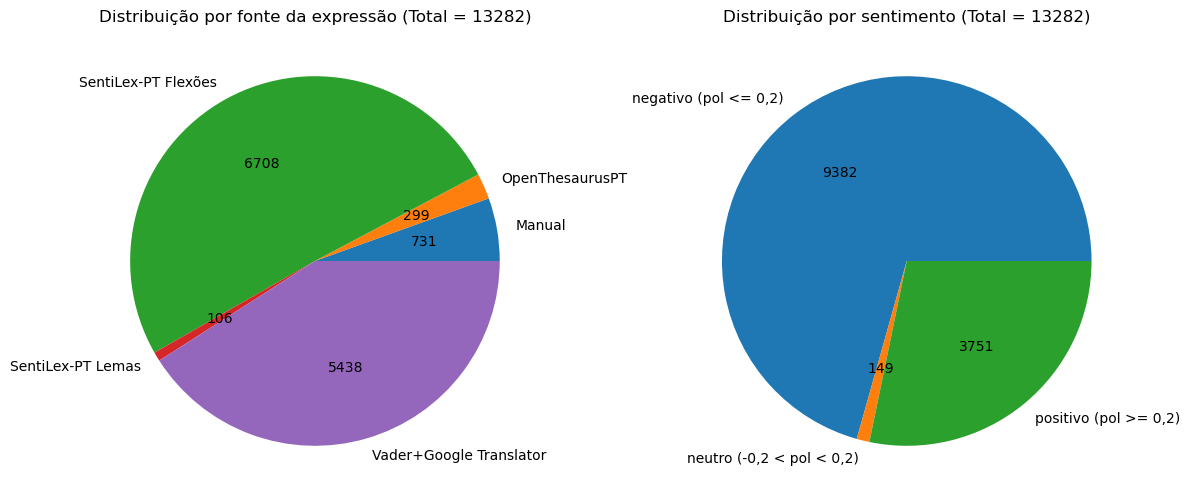

In [13]:
import matplotlib.pyplot as plt

dfFinal = dfAposFlexoes

dfGraficoFonte = dfFinal.groupby('Fonte').count()

dfGraficoQtdeSentimentos = dfFinal

dfGraficoQtdeSentimentos['Classificação'] = dfGraficoQtdeSentimentos['polaridade'].apply(lambda x : 'neutro (-0,2 < pol < 0,2)' if x > -0.2 and x < 0.2 else    ( 'positivo (pol >= 0,2)' if x >= 0.2 else 'negativo (pol <= 0,2)'  )  )

dfGraficoQtdeSentimentos = dfGraficoQtdeSentimentos.groupby('Classificação').count()

plt.figure(figsize = (14, 6))
plt.subplot(1, 2, 1)
plt.pie(dfGraficoFonte['sintagma'], labels=dfGraficoFonte.index, autopct=lambda p: '{:.0f}'.format(p * np.sum(dfGraficoFonte['sintagma']) / 100),  textprops={'fontsize': 10})
plt.title('Distribuição por fonte da expressão (Total = '  + str(np.sum(dfGraficoFonte['sintagma']))+ ')' )

plt.subplot(1, 2, 2)
plt.pie(dfGraficoQtdeSentimentos['sintagma'], labels=dfGraficoQtdeSentimentos.index, autopct=lambda p: '{:.0f}'.format(p * np.sum(dfGraficoQtdeSentimentos['sintagma']) / 100))
plt.title('Distribuição por sentimento (Total = '  + str(np.sum(dfGraficoQtdeSentimentos['sintagma']))+ ')' )
plt.show()
